In [1]:
import pandas as pd
import numpy as np
from scipy.stats import poisson, skellam
import datetime
basetime = datetime.datetime(year=1970, month=1, day=1, hour=1)
import matplotlib.pyplot as plt

%run get_odds.py
%run Helper.py

## New Football Model

We will implement a new Bayesian model which eliminates the use of a home ground advantage variable and instead gives each team different attacking and defensive strength parameters for home and away performances. This should allow the model to consider the different style that teams play during home and away matches.

If we let $\alpha, \beta, \gamma, \rho$ denote the home attacking, home defensive, away attacking and away defensive strengths of a team respectively and denote the home and away teams with subscripts $h$ and $a$ respectively, we have the following model for the amount of goals scored by the home and away side in a football match.

\begin{align}
X_t &\sim \text{Po}(\alpha_h \rho_a)\\
Y_t &\sim \text{Po}(\gamma_a \beta_h).
\end{align}
Thus, if we denote the set of parameters as $\mathbf{\theta}$,

\begin{align}
\text{P}(X_t=x|\mathbf{\theta}) &= \frac{(\alpha_h \rho_a)^{x} e^{-\alpha_h \rho_a}}{x!} \\
\text{P}(Y_t=y|\mathbf{\theta}) &= \frac{(\gamma_a \beta_h)^{y} e^{-\gamma_a \beta_h}}{y!}
\end{align}

and thus the likelihood of a scoreline is 
\begin{align}
\text{L}(X_t=x, Y_t=y) = \frac{(\alpha_h \rho_a)^{x} e^{-\alpha_h \rho_a}}{x!} \frac{(\gamma_a \beta_h)^{y} e^{-\gamma_a \beta_h}}{y!}.
\end{align}

We also allow the 4 parameters of each team vary by describing them with Gamma distributions. So, 

$$\alpha_h \sim \text{Gamma}(p_{\alpha_h}, q_{\alpha_h}), \hspace{1cm} \beta_h \sim \text{Gamma}(p_{\beta_h}, q_{\beta_h}), \hspace{1cm} \gamma_h \sim \text{Gamma}(p_{\gamma_h}, q_{\gamma_h}), \hspace{1cm} \rho_h \sim \text{Gamma}(p_{\rho_h}, q_{\rho_h})$$

Where the pdf of $\alpha_h$ is as follows:
$$ \pi(\alpha_h) = \frac{q_{\alpha_h}^{p_{\alpha_h}}}{\Gamma(p_{\alpha_h})}\alpha_h^{p_{\alpha_h}-1}e^{-q_{\alpha_h}\alpha_h} \hspace{0.5cm} (\alpha_h>0).$$

Thus, we can apply Bayes' theorem to obtain the Bayesian updates for our parameters after each match. From Bayes, we know that

\begin{align}
\text{Posterior} &\propto \text{Likelihood} \times \text{Prior}\\
&\propto (\alpha_h \rho_a)^x e^{-\alpha_h \rho_a} \cdot (\gamma_a \beta_h)^y e^{-\gamma_a \beta_h} \times 
\alpha_h^{p_{\alpha_h}-1}e^{-q_{\alpha_h}\alpha_h} \cdot
\beta_h^{p_{\beta_h}-1}e^{-q_{\beta_h}\beta_h} \cdot
\gamma_a^{p_{\gamma_a}-1}e^{-q_{\gamma_a}\gamma_a} \cdot
\rho_a^{p_{\rho_a}-1}e^{-q_{\rho_a}\rho_a}
\end{align}

and thus we can derive the posterior distributions of parameters $\alpha_h, \beta_h, \gamma_a, \rho_a$ from this result.

$$\pi(\alpha_h|X_t,Y_t) \propto \alpha_h^{p_{\alpha_h}+x-1} e^{-(q_{\alpha_h}+\rho_a)\alpha_h}$$

As $\pi(\alpha_h|X_t,Y_t) \propto \text{Gamma}(p_{\alpha_h}+x, q_{\alpha_h}+\rho_a)$, we can derive the posterior updates for $\alpha_h$

$$ p_{\alpha_h} = \tilde{p}_{\alpha_h} + x,\hspace{0.5cm} q_{\alpha_h} = \tilde{q}_{\alpha_h} + \rho_a $$

We will obtain the corresponding results for $\beta_h, \gamma_a, \rho_a$:

$$\pi(\beta_h|X_t,Y_t) \propto \beta_h^{p_{\beta_h}+y-1} e^{-(q_{\beta_h}+\gamma_a)\beta_h}$$
Thus, 
$$ p_{\beta_h} = \tilde{p}_{\beta_h} + y,\hspace{0.5cm} q_{\beta_h} = \tilde{q}_{\beta_h} + \gamma_a $$

$$\pi(\gamma_a|X_t,Y_t) \propto \gamma_a^{p_{\gamma_a}+y-1} e^{-(q_{\gamma_a}+\beta_h)\gamma_a}$$
Thus, 
$$ p_{\gamma_a} = \tilde{p}_{\gamma_a} + y,\hspace{0.5cm} q_{\beta_h} = \tilde{q}_{\gamma_a} + \beta_h $$

$$\pi(\rho_a|X_t,Y_t) \propto \rho_a^{p_{\rho_a}+x-1} e^{-(q_{\rho_a}+\alpha_h)\rho_a}$$
Thus, 
$$ p_{\rho_a} = \tilde{p}_{\rho_a} + x,\hspace{0.5cm} q_{\rho_a} = \tilde{q}_{\rho_a} + \alpha_h $$

We now have our 4 Bayesian updates and we can begin implementing our new modelling methodology.

In [2]:
class league():
    def __init__(self, teams=None, p_alpha=None, q_alpha=None, alpha_hat=None, p_beta=None, q_beta=None, beta_hat=None,
                p_gamma=None, q_gamma=None, gamma_hat=None, p_rho=None, q_rho=None, rho_hat=None, w=0.9879 , w_b=0.77767, 
                 delta=10,
                 promoted={'p_alpha':44.28, 'q_alpha':53.71, 'p_beta':43.43, 'q_beta':39.29, 
                           'p_gamma':10, 'q_gamma':10, 'p_rho':10, 'q_rho':10}, 
                 relegated={'p_alpha':53.71, 'q_alpha':44.28, 'p_beta':39.29, 'q_beta':43.43, 
                           'p_gamma':10, 'q_gamma':10, 'p_rho':10, 'q_rho':10}, 
                 trained_data=pd.DataFrame()):
        
        self.teams = teams
        if self.teams:
            self.NT = len(teams)
        self.p_alpha = p_alpha
        self.q_alpha = q_alpha
        self.alpha_hat = alpha_hat
        self.p_beta = p_beta
        self.q_beta = q_beta
        self.beta_hat = beta_hat
        self.p_gamma = p_gamma
        self.q_gamma = q_gamma
        self.gamma_hat = gamma_hat
        self.p_rho = p_rho
        self.q_rho = q_rho
        self.rho_hat = rho_hat
        self.w = w
        self.w_b = w_b
        self.delta = delta
        self.promoted = promoted
        self.relegated = relegated
        self.trained_data = trained_data
    
    def initialise(self, teams):
        self.teams = teams
        self.NT = len(teams)
        self.p_alpha = np.array([self.delta]*self.NT, dtype=float)
        self.q_alpha = np.array([self.delta]*self.NT, dtype=float)
        self.alpha_hat = (self.p_alpha)/self.q_alpha
        
        self.p_beta = np.array([self.delta]*self.NT, dtype=float)
        self.q_beta = np.array([self.delta]*self.NT, dtype=float)
        self.beta_hat = self.p_beta/self.q_beta
        
        self.p_gamma = np.array([self.delta]*self.NT, dtype=float)
        self.q_gamma = np.array([self.delta]*self.NT, dtype=float)
        self.gamma_hat = (self.p_gamma-1)/self.q_gamma
        
        self.p_rho = np.array([self.delta]*self.NT, dtype=float)
        self.q_rho = np.array([self.delta]*self.NT, dtype=float)
        self.rho_hat = (self.p_rho-1)/self.q_rho
    
    def train(self, data):
        data.loc[data['FTHG'] > 5, 'FTHG'] = 5
        data.loc[data['FTAG'] > 5, 'FTAG'] = 5
        
        data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
        
        lambdasH = []
        lambdasA = []
        # iterate through data
        for i in range(data.shape[0]):
            match = data.iloc[[i]]
            # get indices of home and away sides
            HT = int(np.arange(self.NT)[self.teams==match.iloc[0].loc['HomeTeam']])
            AT = int(np.arange(self.NT)[self.teams==match.iloc[0].loc['AwayTeam']])
            # get home and away lambda
            lambdaH = self.alpha_hat[HT]*self.rho_hat[AT]
            lambdasH.append(lambdaH)
            
            lambdaA = self.gamma_hat[AT]*self.beta_hat[HT]
            lambdasA.append(lambdaA)
            
            X = int(match['FTHG'])
            Y = int(match['FTAG'])
            
            self.p_alpha[HT] = self.w*self.p_alpha[HT]+X
            self.q_alpha[HT] = self.w*self.q_alpha[AT]+self.rho_hat[AT]
            self.alpha_hat[HT] = (self.p_alpha[HT]-1)/self.q_alpha[HT]

            self.p_beta[HT] = self.w*self.p_beta[HT]+Y
            self.q_beta[HT] = self.w*self.q_beta[HT]+self.gamma_hat[AT]
            self.beta_hat[HT] = (self.p_beta[HT]-1)/self.q_beta[HT]

            self.p_gamma[AT] = self.w*self.p_gamma[AT]+Y
            self.q_gamma[AT] = self.w*self.q_gamma[AT]+self.beta_hat[HT]
            self.gamma_hat[AT] = (self.p_gamma[AT]-1)/self.q_gamma[AT]

            self.p_rho[AT] = self.w*self.p_rho[AT]+X
            self.q_rho[AT] = self.w*self.q_rho[AT]+self.alpha_hat[HT]
            self.rho_hat[AT] = (self.p_rho[AT]-1)/self.q_rho[AT]
        
        phome = 1 - skellam.cdf(0, lambdasH, lambdasA)
        pdraw = skellam.pmf(0, lambdasH, lambdasA)
        paway = 1-phome-pdraw
        P = np.zeros((len(data), 3))
        P[:,0] = phome
        P[:,1] = pdraw
        P[:,2] = paway
        Z = FTRtoZ(data['FTR'])
        data['BS'] = BS(Z, P)
        data['LS'] = LS(Z, P)
        data['PHome'] = phome
        data['PDraw'] = pdraw
        data['PAway'] = paway
        
        self.trained_data = self.trained_data.append(data, ignore_index=True) 

    def predict(self, HomeTeam, AwayTeam):
        HT = int(np.arange(self.NT)[self.teams==HomeTeam])
        AT = int(np.arange(self.NT)[self.teams==AwayTeam])
        LambdaH = self.alpha_hat[HT]*self.rho_hat[AT]
        LambdaA = self.gamma_hat[AT]*self.beta_hat[HT]
        
        home_goals = np.zeros(9)
        away_goals = np.zeros(9)
        for i in range(8):
            home_goals[i] = poisson.pmf(i, LambdaH)
            away_goals[i] = poisson.pmf(i, LambdaA)
        home_goals[8] = 1-sum(home_goals)
        away_goals[8] = 1-sum(away_goals)
        scores = np.zeros((9,9))
        for i in range(9):
            for j in range(9):
                scores[i,j] = home_goals[i]*away_goals[j]
        
        phome = np.tril(scores, -1).sum()
        pdraw = sum(np.diag(scores))
        paway = np.triu(scores, 1).sum()
        
        # most likely result
        result = np.where(scores==np.max(scores))
        result = list(result)
        ml_result = [int(result[0]), int(result[1])]
        
        return({'matrix':scores, 'outcomes':[phome, pdraw, paway], 'result':ml_result})
    
    def new_season(self, teams_out, teams_promoted_in, teams_relegated_in=None):
        # record variables belonging to each team
        tracker=dict({'teams':self.teams, 'p_alpha':self.p_alpha, 'q_alpha':self.q_alpha, 'p_beta':self.p_beta, 
                      'q_beta':self.q_beta, 'p_gamma':self.p_gamma, 'q_gamma':self.q_gamma, 'p_rho':self.p_rho, 
                     'q_rho':self.q_rho})
        #print('Tracker: {}'.format(tracker))
        teams_df = pd.DataFrame(tracker)
        # remove teams exiting league
        teams_out_index = []
        for i in range(len(self.teams)):
            if self.teams[i] in teams_out:
                teams_out_index.append(i)
        self.teams = np.delete(self.teams, teams_out_index)
        # add new teams to the league
        self.teams = np.append(self.teams, teams_promoted_in)
        if teams_relegated_in:
            self.teams = np.append(self.teams, teams_relegated_in)
        self.teams = np.array(sorted(self.teams))

        self.p_alpha = np.array([])
        self.q_alpha = np.array([])
        self.p_beta = np.array([])
        self.q_beta = np.array([])
        self.p_gamma = np.array([])
        self.q_gamma = np.array([])
        self.p_rho = np.array([])
        self.q_rho = np.array([])
        for i in range(self.NT):
            if self.teams[i] in list(teams_df['teams']):
                team_data = teams_df[teams_df['teams']==self.teams[i]]
                w_b = self.w_b
            elif self.teams[i] in list(teams_promoted_in):
                team_data = self.promoted
                w_b = 1
            elif self.teams[i] in list(teams_relegated_in):
                team_data = self.relegated
                w_b = 1
                
            self.p_alpha = np.append(self.p_alpha, w_b*float(team_data['p_alpha']))
            self.q_alpha = np.append(self.q_alpha, w_b*float(team_data['q_alpha']))
            self.p_beta = np.append(self.p_beta, w_b*float(team_data['p_beta']))
            self.q_beta = np.append(self.q_beta, w_b*float(team_data['q_beta']))
            self.p_gamma = np.append(self.p_gamma, w_b* float(team_data['p_gamma']))
            self.q_gamma = np.append(self.q_gamma, w_b*float(team_data['q_gamma']))
            self.p_rho = np.append(self.p_rho, w_b* float(team_data['p_rho']))
            self.q_rho = np.append(self.q_rho, w_b*float(team_data['q_rho']))
            
        self.alpha_hat = (self.p_alpha-1)/self.q_alpha
        self.beta_hat = (self.p_beta-1)/self.q_beta
        self.gamma_hat = (self.p_gamma-1)/self.q_gamma
        self.rho_hat = (self.p_rho-1)/self.q_rho
        
    def train_all(self, league_str, league_below=None, league_above=None, SEA = list(range(1996, 2021))):
        NS = []
        NS_below = []
        NS_above = []
        for i in SEA:
            NS.append('AutoData/'+str(i)+league_str+'.csv')
            if league_below:
                NS_below.append('AutoData/'+str(i)+league_below+'.csv')
            if league_above:
                NS_above.append('AutoData/'+str(i)+str(league_above)+'.csv')
        
        data = pd.read_csv(NS[0])
        data = data[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
        teams = np.unique(data['HomeTeam'])
        
        self.teams = teams
        self.NT = len(teams)

        if league_below:
            data_below = pd.read_csv(NS_below[0])
            data_below = data_below[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
            teams_below = np.unique(data_below['HomeTeam'])

        if league_above:
            data_above = pd.read_csv(NS_above[0])
            data_above = data_above[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
            teams_above = np.unique(data_above['HomeTeam'])

        #print('Season: ' + str(SEA[0]), end="\r")
        self.initialise(teams)
        self.train(data)
        matches = data.shape[0]
        seasons = [SEA[0]]*matches
        promoted_in=None
        relegated_in=None
        for i in range(1, len(NS)):
            #print('Season: ' + str(SEA[i]), end="\r")
            old_data = data
            old_teams = teams    
            data = pd.read_csv(NS[i], encoding = 'unicode_escape')
            data = data[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
            matches = data.shape[0]
            seasons = np.append(seasons, [SEA[i]]*matches)
            teams = np.unique(data['HomeTeam'])
            teams_out = list(set(old_teams) - set(teams))

            if league_below:
                old_data_below = data_below
                old_teams_below = teams_below
                data_below = pd.read_csv(NS_below[i], encoding = 'unicode_escape')
                data_below = data_below[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
                teams_below = np.unique(data_below['HomeTeam'])

            if league_above:
                old_data_above = data_above
                old_teams_above = teams_above
                data_above = pd.read_csv(NS_above[i], encoding = 'unicode_escape')
                data_above = data_above[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
                teams_above = np.unique(data_above['HomeTeam'])

            if league_below:
                promoted_in =  sorted(list(set(old_teams_below) & set(teams)))
            if league_above:
                relegated_in = sorted(list(set(old_teams_above) & set(teams)))
                
            if not (league_below or league_above):
                promoted_in =  sorted(list(set(teams) - set(old_teams)))

            #print('Teams Out:' + str(teams_out))
            #print('Promoted In:' + str(promoted_in))
            self.new_season(teams_out, promoted_in, relegated_in)
            self.train(data)
        self.trained_data.insert(0, 'SEA', seasons)
        #print('Training Complete')
    
    def betting_odds(self, league_str, SEA=list(range(2006, 2022))):
        NS = []
        for i in SEA:
            NS.append('BettingData/'+str(i)+league_str+'.csv')
        j=0
        for i in range(len(NS)):
            if SEA[i] < 2020:
                newdata = pd.read_csv(NS[i])
            else:
                newdata = pd.read_csv(NS[i])
                columns = list(newdata.columns)
                for j in range(len(columns)):
                    column = columns[j]
                    columns[j] = re.sub('Max', 'BbMx', column)
                newdata.columns = columns
            
            newdata['Date'] = pd.to_datetime(newdata['Date'], dayfirst=True)
            newdata.insert(1, 'SEA', SEA[i])
                
            if j==0:
                data = newdata[['Div', 'SEA', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'BbMxH', 'BbMxD', 'BbMxA']]
            else:
                data = data.append(newdata[['Div', 'SEA', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'BbMxH', 'BbMxD', 'BbMxA']], 
                                  ignore_index=True)
            j += 1
        data['BetHome'] = 1/data['BbMxH']
        data['BetDraw'] = 1/data['BbMxD']
        data['BetAway'] = 1/data['BbMxA']
        return data


In [3]:
PL = league()
PL.train_all('E0', SEA = range(1996, 2022))

In [4]:
league_BS, league_LS = [], []
for i in np.unique(PL.trained_data['SEA']):
    league_data = PL.trained_data[PL.trained_data['SEA']==i]
    avg_BS = np.mean(league_data['BS'])
    avg_LS = np.mean(league_data['LS'])
    league_BS.append(avg_BS)
    league_LS.append(avg_LS)

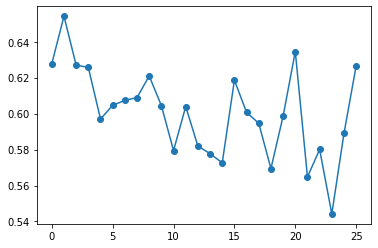

In [10]:
plt.plot(league_BS, marker='o')
plt.show()

## Optimise our nuisance parameters 

In [11]:
from scipy.optimize import minimize
def PL_opt(x):
    PL = league(w=logit(x[0]), w_b=logit(x[1]), 
               promoted={'p_alpha':np.exp(x[2]), 'q_alpha':np.exp(x[3]), 
                         'p_beta':np.exp(x[4]), 'q_beta':np.exp(x[5]), 
                        'p_gamma':np.exp(x[6]), 'q_gamma':np.exp(x[7]), 
                        'p_rho':np.exp(x[8]), 'q_rho':np.exp(x[9])})
    PL.train_all(league_str='E0', league_below='E1', SEA=range(1996, 2011))
    return np.mean(PL.trained_data['BS'])

In [16]:
PL_fit = minimize(PL_opt, [4.8, 1, 5, 5, 5, 5, 5, 5, 5, 5], method='BFGS', options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.594960
         Iterations: 101
         Function evaluations: 1155
         Gradient evaluations: 105


In [17]:
par = PL_fit['x']
print('w: {} \nw_b: {} \np_alpha: {} \nq_alpha: {} \np_beta: {} \nq_beta: {} \np_gamma: {} \nq_gamma: {} \np_rho: {} \nq_rho: {}'.format(par[0], par[1], par[2], par[3], par[4], par[5], par[6], par[7], par[8], par[9]))

w: 3.4203062614353223 
w_b: 15.206962036516025 
p_alpha: 3.5050217309836467 
q_alpha: 3.6985575147660144 
p_beta: 3.465232348809865 
q_beta: 3.3105472696376363 
p_gamma: 3.2736570672849963 
q_gamma: 3.677123766748855 
p_rho: 7.362972767394369 
q_rho: 6.998687021828725


In [24]:
logit(PL_fit['x'][:2]), np.exp(PL_fit['x'][2:])

(array([0.96833316, 0.99999975]),
 array([  33.2821671 ,   40.38900178,   31.98389033,   27.40011662,
          26.40773784,   39.53252563, 1576.51621976, 1095.19424787]))

In [30]:
PL_fit(np.exp(3.7)/np.exp(4)

0.7408182206817181